# Analysis of NYC 311 Service Requests

This is an analysis of service requests in New York City dating back from 2010 to March of this year. The data can be found at: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

With the size of the data being around 10.7 GB and my machine being a Macbook Air in its last days - utilizing the cloud to compute was my only option. I first downloaded the file into my AWS S3 storage and then opened up an EC2 instance to compute.

In [1]:
import pandas as pd
import boto3
import io

In [2]:
client = boto3.client('s3') #low-level functional API
resource = boto3.resource('s3') #high-level object-oriented API
my_bucket = resource.Bucket('interview-stuff') #subsitute this for your s3 bucket name. 

In [54]:
obj = client.get_object(Bucket='interview-stuff', Key='311_service_requests.csv')

In [55]:
df = pd.read_csv(io.BytesIO(obj['Body'].read()), dtype={'Incident Zip': 'str'})

/home/ec2-user/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (17,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Question: What are the top features that affect the time to resolve a complaint? Do they change over time?

## Initial Processing

First step was to the initial wrangling done in Pandas. Initial impressions from the data show that there are a lot of columns displaying sparsity and redudancy. I initally set a minimum threshold of non-null values that a column could have for it to be dropped. 

## Feature Selection

With not many of the features remaining contributing useful information - I wanted to observe four main factors that could affect the time to resolve a complaint: Agency, type of complaint, location, and the time. The four columns in this dataset that were used: Agency Name, Complaint Type, Incident Zip, and Borough. I also extracted the month and year from the date created column.

## Feature Processing

3 of the four features chosen exhibited high cardinality:
- Agency Name I kept the top 12 frequently occuring agencies and grouped the remaining as other
- Complaint Type and Incident Zip was a bit more difficult due to the messiness of the columns - The cardinalities were not as high as agency name so a different approach was taken
    - I used the pandas groupby function to create a new column with the count of each complaint type and zip code


In [5]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26435528,10/04/2013 08:32:00 AM,10/04/2013 08:37:00 AM,DEP,Department of Environmental Protection,Water System,Dirty Water (WE),NaN,10022,325 EAST 54 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.757069,-73.965933,"(40.75706852462872, -73.96593314322774)"
1,26435529,10/04/2013 12:21:00 PM,10/04/2013 12:23:00 PM,DEP,Department of Environmental Protection,Water System,Dirty Water (WE),NaN,10022,250 EAST 54 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.757835,-73.967792,"(40.757834843087686, -73.96779168686822)"
2,26435531,10/04/2013 12:22:00 PM,10/04/2013 06:00:00 PM,DEP,Department of Environmental Protection,Water System,Dirty Water (WE),NaN,11235,2461 EAST 13 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.590727,-73.956747,"(40.59072661066776, -73.95674658536144)"
3,26435532,10/04/2013 12:28:00 PM,10/05/2013 11:52:00 AM,DEP,Department of Environmental Protection,Asbestos,Asbestos Complaint (B1),NaN,11378,70-02 54 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.729215,-73.893624,"(40.729214615878035, -73.89362433399548)"
4,26435533,10/04/2013 08:45:00 AM,10/04/2013 08:50:00 AM,DEP,Department of Environmental Protection,Water System,Dirty Water (WE),NaN,10022,214 EAST 51 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756208,-73.969760,"(40.7562077426825, -73.96975964862594)"


In [6]:
df.shape

(17312578, 53)

In [6]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17312578 entries, 0 to 17312577
Data columns (total 53 columns):
Unique Key                        17312578 non-null int64
Created Date                      17312578 non-null object
Closed Date                       16728443 non-null object
Agency                            17312578 non-null object
Agency Name                       17312578 non-null object
Complaint Type                    17312578 non-null object
Descriptor                        17132890 non-null object
Location Type                     12852719 non-null object
Incident Zip                      16110560 non-null object
Incident Address                  13525995 non-null object
Street Name                       13524870 non-null object
Cross Street 1                    11816846 non-null object
Cross Street 2                    11748688 non-null object
Intersection Street 1             2666954 non-null object
Intersection Street 2             2662504 non-null object
Add

In [58]:
df1 = df.dropna(axis=1, thresh=12852719)
df1.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17312578 entries, 0 to 17312577
Data columns (total 34 columns):
Unique Key                        17312578 non-null int64
Created Date                      17312578 non-null object
Closed Date                       16728443 non-null object
Agency                            17312578 non-null object
Agency Name                       17312578 non-null object
Complaint Type                    17312578 non-null object
Descriptor                        17132890 non-null object
Location Type                     12852719 non-null object
Incident Zip                      16110560 non-null object
Incident Address                  13525995 non-null object
Street Name                       13524870 non-null object
Address Type                      16494949 non-null object
City                              16116236 non-null object
Status                            17312545 non-null object
Resolution Description            16636310 non-null object
R

In [59]:
columns = ['Unique Key', 'Created Date', 'Closed Date', 'Agency Name', 'Complaint Type', 'Borough', 'Incident Zip']

df2 = df1[columns]

In [14]:
df2.head()

,Unique Key,Created Date,Closed Date,Agency Name,Complaint Type,Borough,Incident Zip
0,26435528,10/04/2013 08:32:00 AM,10/04/2013 08:37:00 AM,Department of Environmental Protection,Water System,MANHATTAN,10022
1,26435529,10/04/2013 12:21:00 PM,10/04/2013 12:23:00 PM,Department of Environmental Protection,Water System,MANHATTAN,10022
2,26435531,10/04/2013 12:22:00 PM,10/04/2013 06:00:00 PM,Department of Environmental Protection,Water System,BROOKLYN,11235
3,26435532,10/04/2013 12:28:00 PM,10/05/2013 11:52:00 AM,Department of Environmental Protection,Asbestos,QUEENS,11378
4,26435533,10/04/2013 08:45:00 AM,10/04/2013 08:50:00 AM,Department of Environmental Protection,Water System,MANHATTAN,10022


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17312578 entries, 0 to 17312577
Data columns (total 7 columns):
Unique Key        int64
Created Date      object
Closed Date       object
Agency Name       object
Complaint Type    object
Incident Zip      object
Borough           object
dtypes: int64(1), object(6)
memory usage: 924.6+ MB


In [11]:
df2['Agency Name'].value_counts()

Department of Housing Preservation and Development                          5033139
New York City Police Department                                             3793714
Department of Transportation                                                2375751
Department of Environmental Protection                                      1396446
Department of Parks and Recreation                                           762024
Department of Buildings                                                      716943
Department of Health and Mental Hygiene                                      440655
Department of Sanitation                                                     223055
Department of Finance                                                        203059
Taxi and Limousine Commission                                                193082
Department of Consumer Affairs                                               169051
BCC - Brooklyn South                                                        

In [12]:
df2['Complaint Type'].value_counts()

Noise - Residential                  1396720
HEATING                               887869
HEAT/HOT WATER                        883327
Street Condition                      798271
Street Light Condition                785409
Blocked Driveway                      670300
PLUMBING                              632254
Illegal Parking                       580791
Water System                          526614
GENERAL CONSTRUCTION                  500863
Noise                                 372338
Traffic Signal Condition              363236
PAINT - PLASTER                       361258
UNSANITARY CONDITION                  318179
Noise - Street/Sidewalk               305422
Sewer                                 299812
Dirty Conditions                      283323
Noise - Commercial                    271953
ELECTRIC                              267117
PAINT/PLASTER                         262909
NONCONST                              260890
General Construction/Plumbing         244214
Sanitation

In [60]:
df2['Incident Zip'].value_counts()

11226         307486
10467         260438
11207         228171
10458         226165
10453         214216
10468         208822
11221         205562
10452         199605
11208         197020
10457         196320
11385         195258
10031         188592
10456         188072
11213         182290
11233         180615
11225         175881
11216         174124
11212         173510
10032         171811
11203         170528
11230         161468
10472         159259
11234         152399
11235         149664
10462         149500
11238         149261
11220         147489
11211         146734
10040         145840
10466         144432
               ...  
296160759          1
92036              1
33467              1
34987              1
19101-7829         1
31082              1
63006              1
77403              1
19850-7125         1
61702-3068         1
10532-1533         1
61826              1
10968              1
78596              1
98277              1
60611              1
11357-1656   

In [15]:
df2['Borough'].value_counts()

BROOKLYN         4973147
QUEENS           3791173
MANHATTAN        3340906
BRONX            2997650
Unspecified      1386651
STATEN ISLAND     823051
Name: Borough, dtype: int64

In [61]:
departments = ['Department of Housing Preservation and Development', 'New York City Police Department',                                                  
'Department of Transportation', 'Department of Environmental Protection','Department of Parks and Recreation',                                           
'Department of Buildings', 'Department of Health and Mental Hygiene', 'Department of Sanitation','Department of Finance',
              'Taxi and Limousine Commission', 'Department of Consumer Affairs']

In [62]:
df2 = df2.copy()
df2['Agency Name'] = df2['Agency Name'].apply(lambda x: x if x in departments else 'Other')

In [63]:
df2['Agency Name'].value_counts()

Department of Housing Preservation and Development    5033139
New York City Police Department                       3793714
Department of Transportation                          2375751
Other                                                 2005659
Department of Environmental Protection                1396446
Department of Parks and Recreation                     762024
Department of Buildings                                716943
Department of Health and Mental Hygiene                440655
Department of Sanitation                               223055
Department of Finance                                  203059
Taxi and Limousine Commission                          193082
Department of Consumer Affairs                         169051
Name: Agency Name, dtype: int64

In [65]:
# Create new complaint count column

df2['Complaint Count'] = df2.groupby('Complaint Type')['Complaint Type'].transform('count')

In [87]:
# Create new zip code count column

df2['Zip Count'] = df2.groupby('Incident Zip')['Incident Zip'].transform('count')
df2['Zip Count'] = df2['Zip Count'].fillna(0).astype(int)
df2['Zip Count'] = df2['Zip Count'].astype(int)

In [66]:
# Create target column - difference between date closed and date created

df2['Created Date'] = pd.to_datetime(df2['Created Date'], format="%m/%d/%Y %I:%M:%S %p")
df2['Closed Date'] = pd.to_datetime(df2['Closed Date'], errors='coerce', format="%m/%d/%Y %I:%M:%S %p")
df2 = df2[df2['Closed Date'].notnull()]

## Target Variable Exploratory Analysis

- Target variable: length in time between service request date created and date closed in days (Time Elapsed)
- I dropped all instances where the date closed was earler than the date created assuming that those instances were mistakes in data collection
- I then observed the distribution of the target column and began observing the feature-target relationship

In [67]:
import numpy as np

df2['Time Elapsed'] = (df2['Closed Date'] - df2['Created Date'])
df2['Time Elapsed'] = df2['Time Elapsed'].astype('timedelta64[D]')
df2['Month'] = df2['Created Date'].dt.month
df2['Year'] = df2['Created Date'].dt.year

In [68]:
errors = df2[df2['Created Date'] > df2['Closed Date']]
df2 = df2[~df2.index.isin(errors.index)]

In [69]:
df2.head()

,Unique Key,Created Date,Closed Date,Agency Name,Complaint Type,Borough,Incident Zip,Complaint Count,Zip Count,Time Elapsed,Month,Year
0,26435528,2013-10-04 08:32:00,2013-10-04 08:37:00,Department of Environmental Protection,Water System,MANHATTAN,10022,526614,67474.0,0.0,10,2013
1,26435529,2013-10-04 12:21:00,2013-10-04 12:23:00,Department of Environmental Protection,Water System,MANHATTAN,10022,526614,67474.0,0.0,10,2013
2,26435531,2013-10-04 12:22:00,2013-10-04 18:00:00,Department of Environmental Protection,Water System,BROOKLYN,11235,526614,149664.0,0.0,10,2013
3,26435532,2013-10-04 12:28:00,2013-10-05 11:52:00,Department of Environmental Protection,Asbestos,QUEENS,11378,16315,77545.0,0.0,10,2013
4,26435533,2013-10-04 08:45:00,2013-10-04 08:50:00,Department of Environmental Protection,Water System,MANHATTAN,10022,526614,67474.0,0.0,10,2013


In [72]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 8)

## Target Variable Initial Thoughts

- As seen in the first histogram the target variable is sparse
- The first box plot taking a look at the time elapsed by month shows that there are some massive outliers ranging to 70000 days in between the date created and closed which also don't seem feasible
- To improve the distribution and remove the intense outliers I only looked at instances that had were dealt with within a year of the request creation

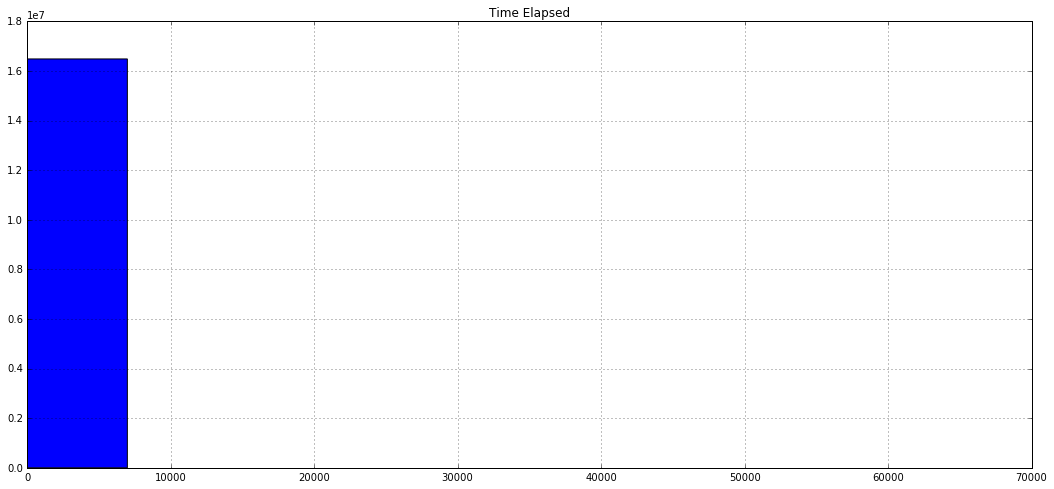

In [14]:
df2['Time Elapsed'].hist()
plt.title('Time Elapsed')
plt.show()

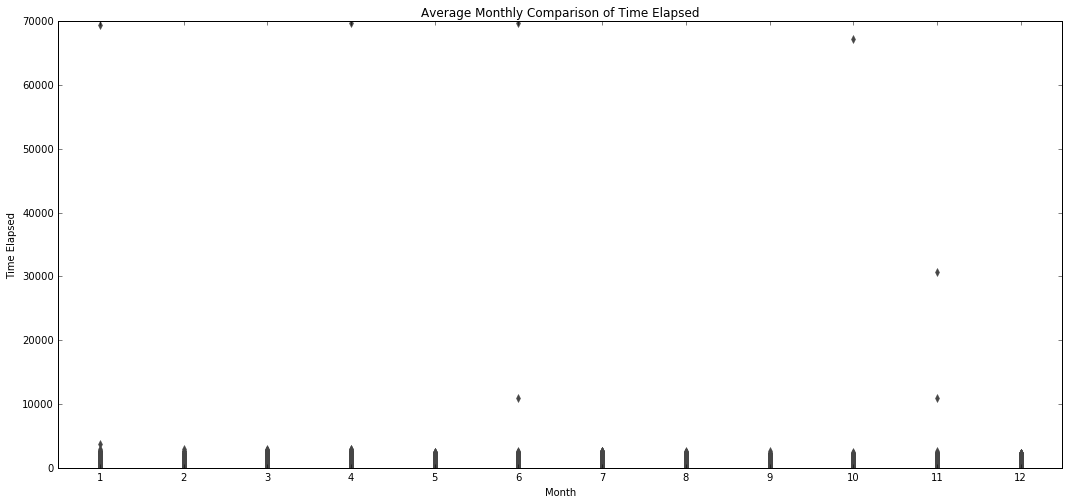

In [24]:
sb.boxplot(x='Month', y='Time Elapsed', data=df2)
plt.title('Average Monthly Comparison of Time Elapsed')
plt.show()

## Further Target Variable Analysis

- After only including service requests dealt with within a year - the distribution is improved but still clearly sparse
- Looked at box plots at processed features that did not have high cardinality: month, year, agency, and borough
- Tough to see much of a difference between feature instances due to the sparsity of our target variable
- However for Agency Name the skew is not as bad for some and we can see distinguishable relationships

In [70]:
# reduce to only within a year

df2 = df2[df2['Time Elapsed'] < 365]

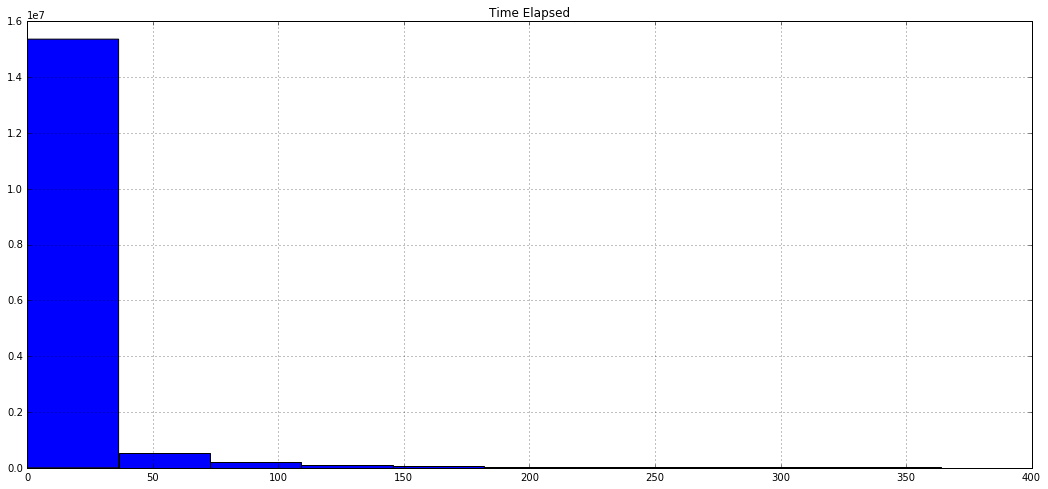

In [73]:
df2['Time Elapsed'].hist()
plt.title('Time Elapsed')
plt.show()

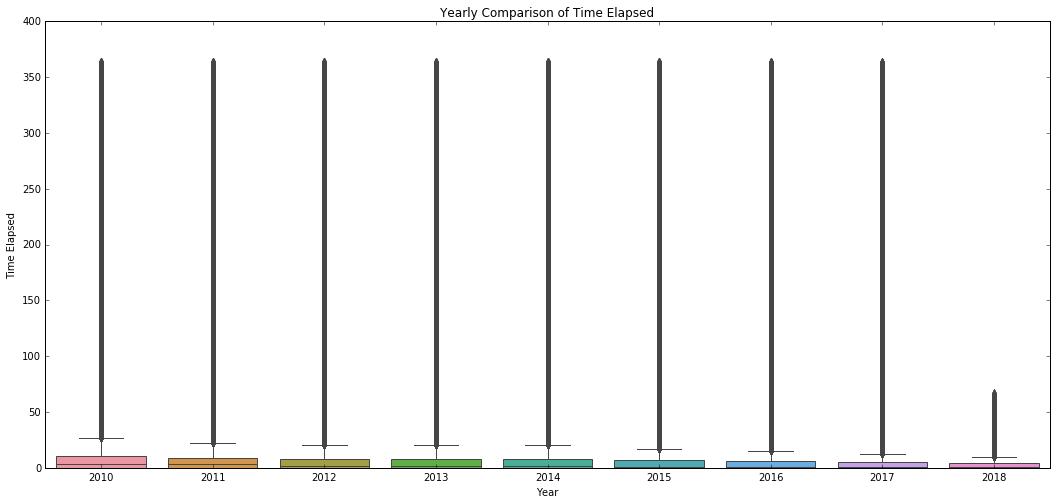

In [27]:
sb.boxplot(x='Year', y='Time Elapsed', data=df2)
plt.title('Yearly Comparison of Time Elapsed')
plt.show()

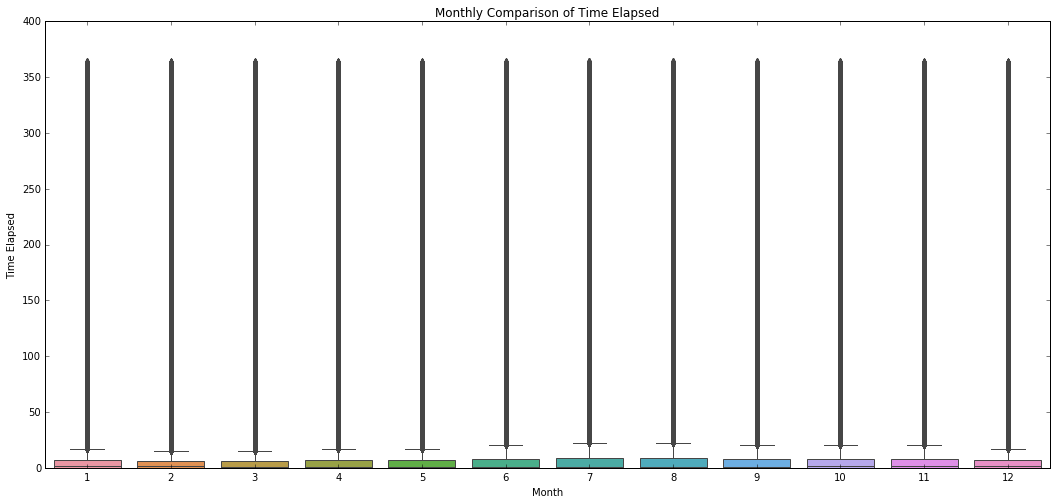

In [30]:
sb.boxplot(x='Month', y='Time Elapsed', data=df2)
plt.title('Monthly Comparison of Time Elapsed')
plt.show()

In [ ]:
# Department of Sanitation, Department of Buildings, Department of Health and Mental Hygiene 

sb.boxplot(x='Agency Name', y='Time Elapsed', data=df2)
plt.title('Agency Comparison of Time Elapsed')
plt.xticks(rotation='vertical')
plt.show()

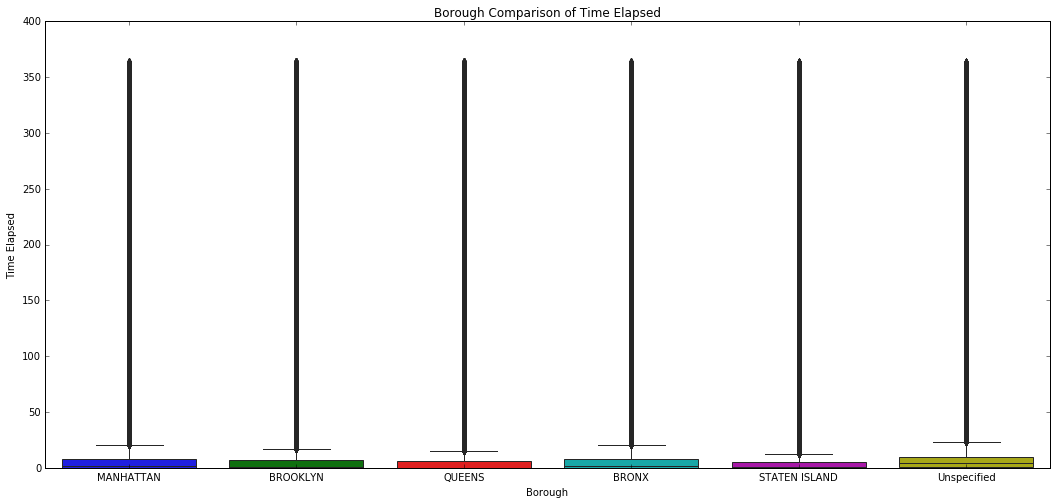

In [32]:
sb.boxplot(x='Borough', y='Time Elapsed', data=df2)
plt.title('Borough Comparison of Time Elapsed')
plt.show()

# Modeling

- From the initial exploratory analysis there does not appear to be a linear relationship between the features and the target variable
- A non-linear model such as a decision tree seems to be a good idea due to the structure of the data as well as the desire for intrepretability
- Dummy variables for created for Borough and Agency Name since they aren't ordinal in nature

## Evaluation

- I chose to use the Root mean squared error to evaluate the model
- I tried an ensemble method after the decision tree to see how badly the first model was overfitting without incorporating cross validation
    - I chose a bagged random forest as opposed to a boosted model for simply computational purposes
- Used the feature importances attribute to observe the most important features

In [88]:
df3 = df2[['Month', 'Year', 'Agency Name', 'Complaint Count', 'Borough', 'Zip Count']]
df3 = pd.get_dummies(df3)
df3['Time Elapsed'] = df2['Time Elapsed']

In [89]:
df3.head()

,Month,Year,Complaint Count,Zip Count,Agency Name_Department of Buildings,Agency Name_Department of Consumer Affairs,Agency Name_Department of Environmental Protection,Agency Name_Department of Finance,Agency Name_Department of Health and Mental Hygiene,Agency Name_Department of Housing Preservation and Development,...,Agency Name_New York City Police Department,Agency Name_Other,Agency Name_Taxi and Limousine Commission,Borough_BRONX,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Borough_Unspecified,Time Elapsed
0,10,2013,526614,67474,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
1,10,2013,526614,67474,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
2,10,2013,526614,149664,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
3,10,2013,16315,77545,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
4,10,2013,526614,67474,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0


In [76]:
len(df3)

16388939

In [90]:
from sklearn import tree, ensemble, model_selection

features = [col for col in df3.columns if col != 'Time Elapsed']

X_train, X_test, y_train, y_test = model_selection.train_test_split(df3[features].values, 
                                                                    df3["Time Elapsed"].values, 
                                                                    test_size=0.3, random_state=42)

In [91]:
from sklearn import metrics
import math
dtree = tree.DecisionTreeRegressor()
dtree_model = dtree.fit(X_train, y_train)
predictions = dtree_model.predict(X_test)
print("RMSE Results", math.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE Results 24.05367753250577


In [92]:
# Random forest provides marginal improvement

rf = ensemble.RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
print('RMSE Results', math.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE Results 23.482201926175218


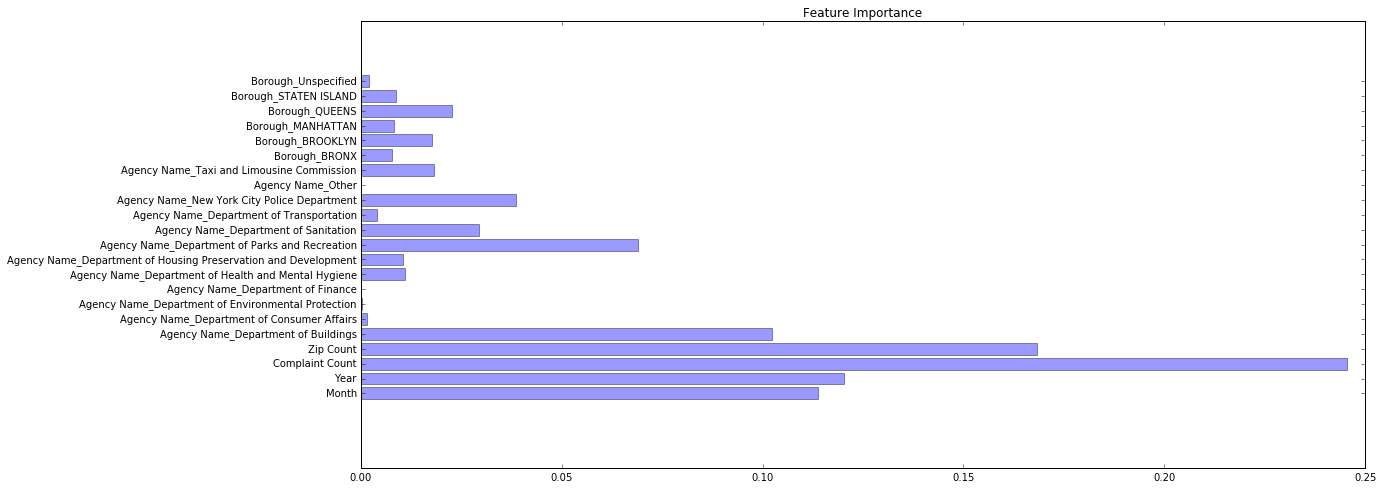

In [93]:
y_pos = np.arange(len(features))

plt.barh(y_pos, dtree_model.feature_importances_, align='center', alpha=0.4)
plt.yticks(y_pos, features)
plt.title('Feature Importance')

plt.show()

In [ ]:
# Further visualization to observe key splits in the decision tree

from IPython.display import Image 
import pydotplus 

output = dtree_model.predict(X_train)
image_tree_model = dtree.fit(X_train, output)

dot_data = tree.export_graphviz(image_tree_model, out_file=None, 
                         feature_names=features,  
                         class_names="Time Elapsed",  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
picture = Image(graph.create_png())

picture

# Feature Importance Changes Over Time

To observe the change in important features over time I created a function identical to the pipeline I used for the inital model that takes in a dataframe and the year and returns the evaluated RMSE as well as the most important features

In [25]:
df3['Year'].value_counts()

2017    2367394
2016    2283244
2015    2194599
2014    2029354
2010    1908170
2013    1776429
2011    1748439
2012    1713291
2018     465157
Name: Year, dtype: int64

In [27]:
def tree_features(df, year):
    df = df[df['Year'] == year]
    df.drop('Year', axis=1, inplace=True)
    
    features = [col for col in df.columns if col != 'Time Elapsed']
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features].values, 
                                                                    df["Time Elapsed"].values, 
                                                                    test_size=0.3, random_state=42)
    
    dtree = tree.DecisionTreeRegressor()
    dtree_model = dtree.fit(X_train, y_train)
    predictions = dtree_model.predict(X_test)
    
    y_pos = np.arange(len(features))

    plt.barh(y_pos, dtree_model.feature_importances_, align='center', alpha=0.4)
    plt.yticks(y_pos, features)
    plt.title('Feature Importance')

    plt.show()
    
    print("RMSE Results", math.sqrt(metrics.mean_squared_error(y_test, predictions)))

## 2010

- In 2010 the type of complaint appears to be the most important with the zip code and month not far behind, the most important agency in predicting was the Department of Buildings

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


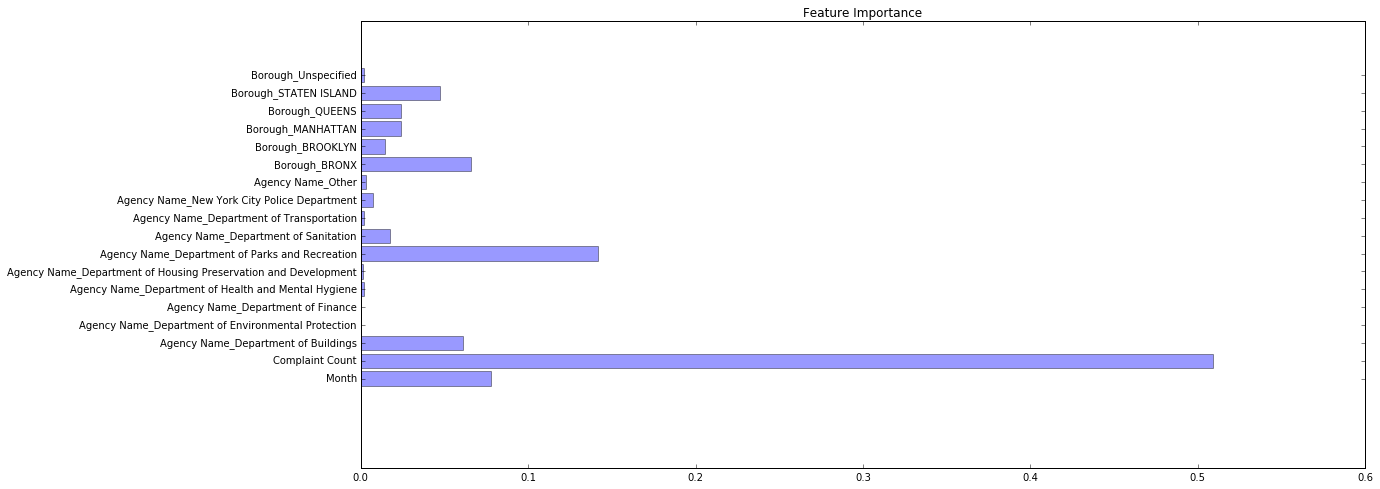

RMSE Results 67.41104864661992


In [28]:
tree_features(df3, 2010)

## 2011

- In 2011 the complaint type, zip code, and month are all still most important however the Department of Buildings displays increased predictive performance

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


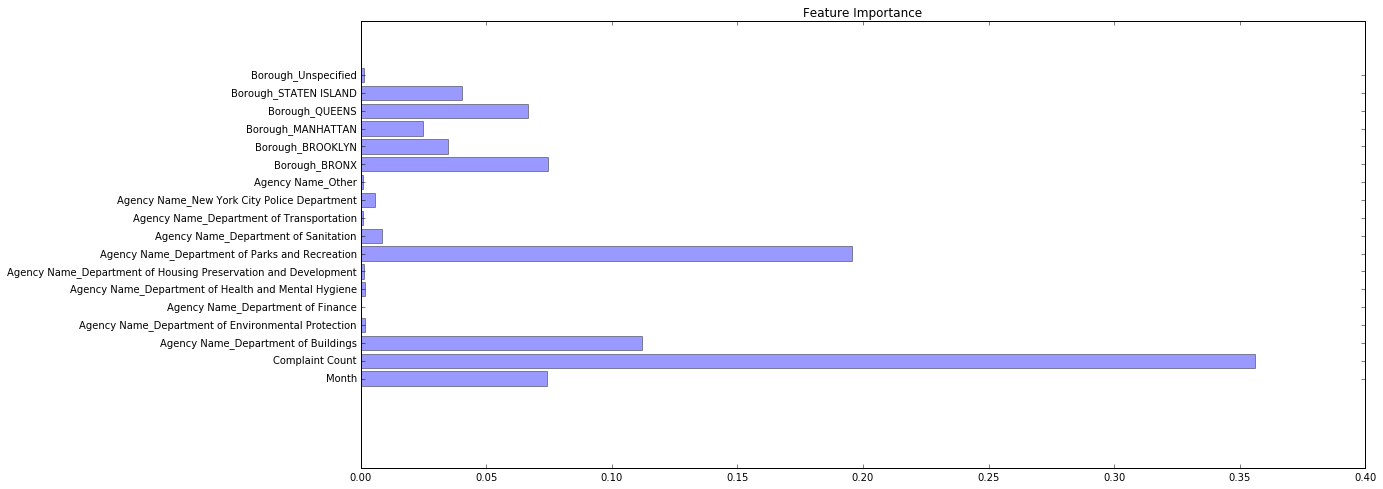

RMSE Results 61.023228987510926


In [29]:
tree_features(df3, 2011)

## 2012

- The Department of Buildings in 2012 increases in feature importance again


/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


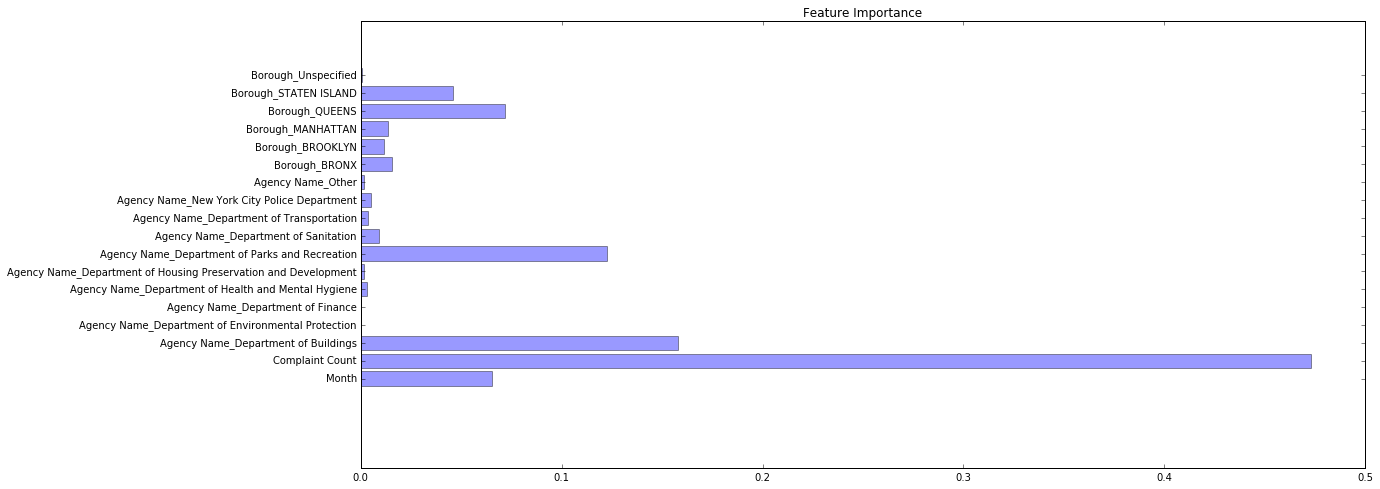

RMSE Results 62.06336469932774


In [30]:
tree_features(df3, 2012)

## 2013

- In 2013 the Deparment of Buildings importance decreased as well, as a result the Department of Sanitation as well as the Department of Parks and Recreation are improved predictors

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


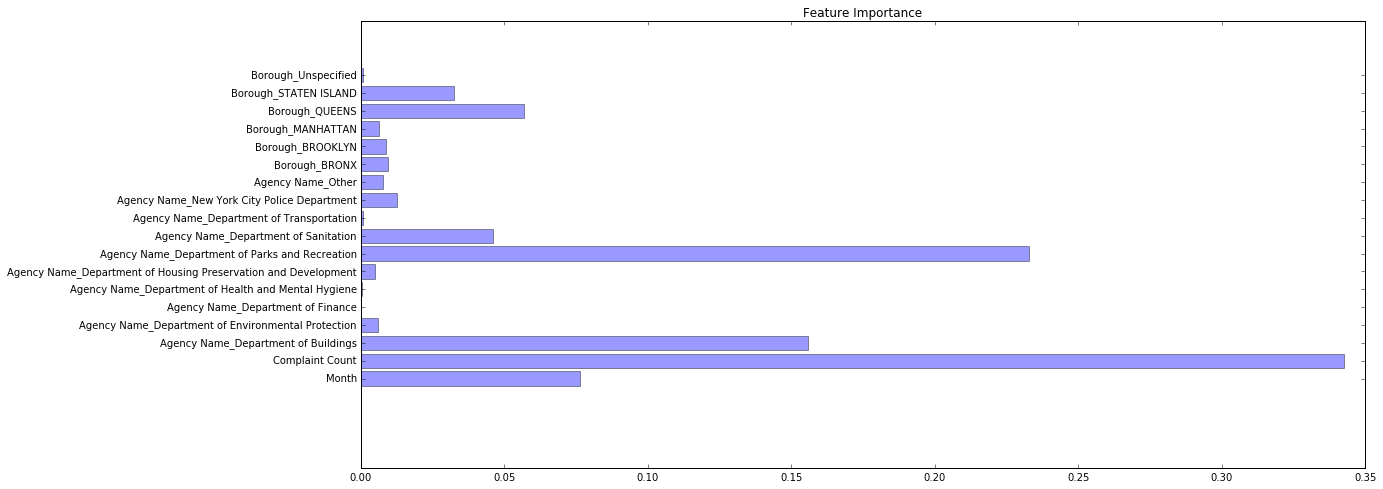

RMSE Results 50.90897843839748


In [31]:
tree_features(df3, 2013)

## 2014

- In 2014 the Department of Buildings importance in prediction decreases again

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


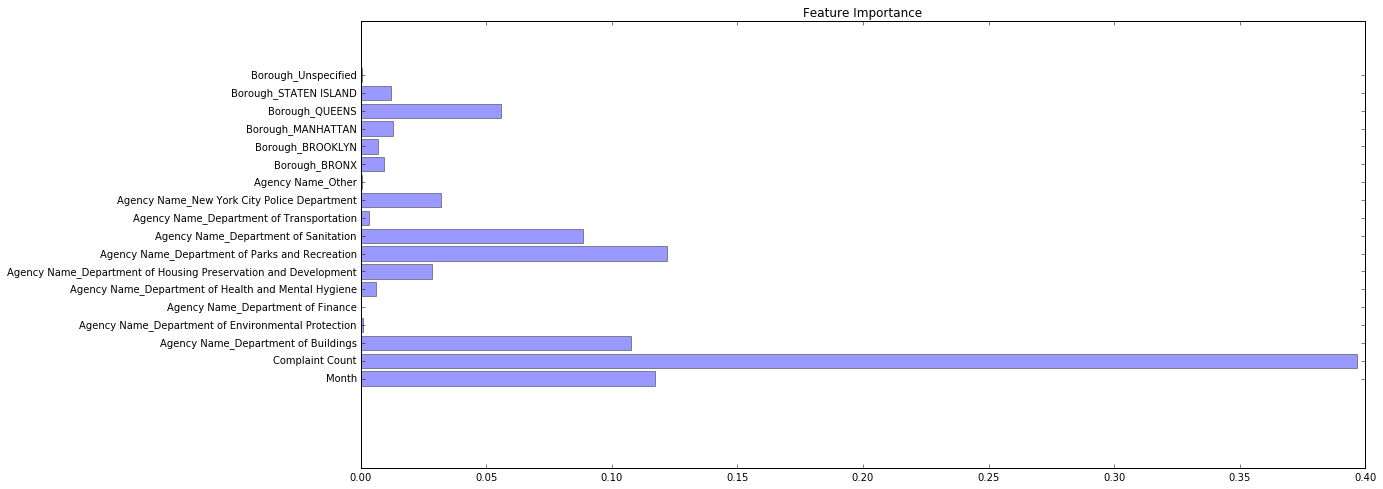

RMSE Results 45.32043945283576


In [32]:
tree_features(df3, 2014)

## 2015

- In 2015 the Department of Buildings goes back to being the most important agency in the model


/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


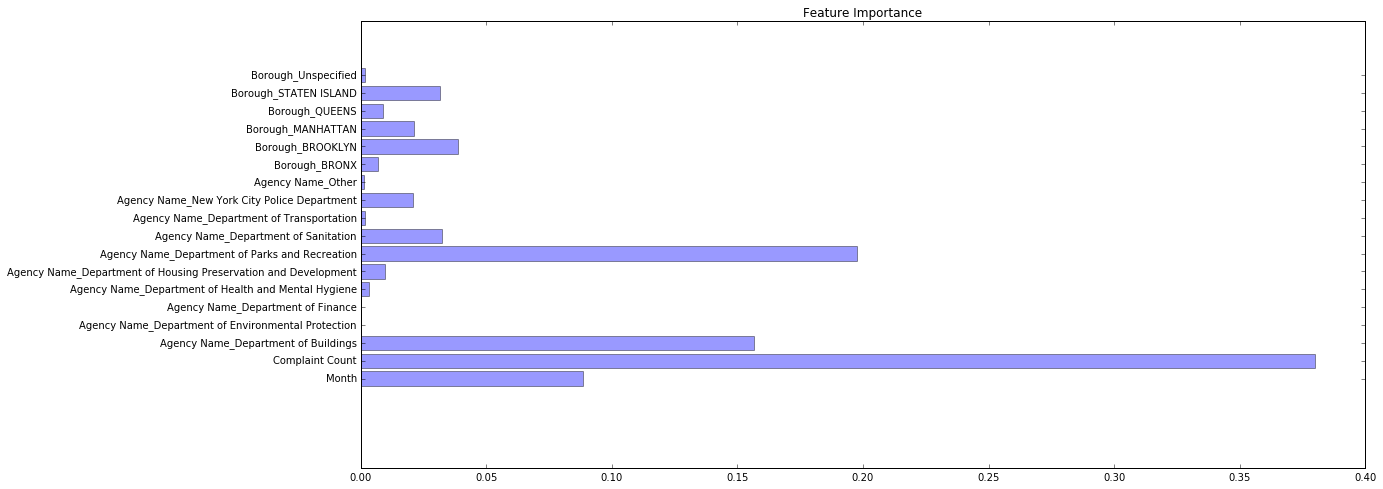

RMSE Results 42.78571261443633


In [33]:
tree_features(df3, 2015)

## 2016

- In 2016 Sanitation along with Parks and Recreation have increased importance


/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


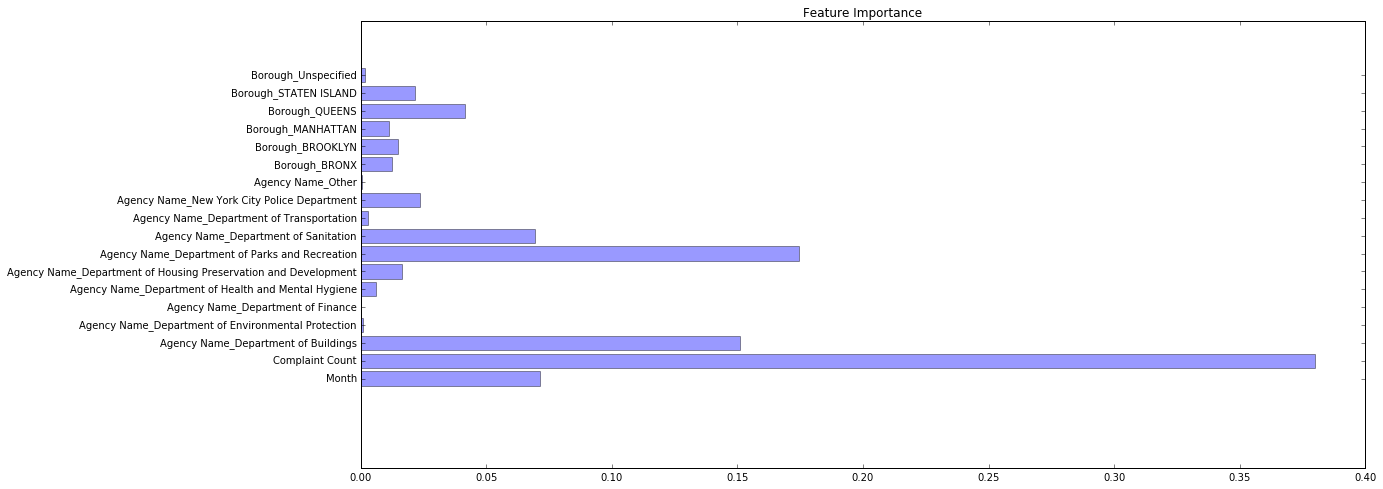

RMSE Results 33.24501054022908


In [34]:
tree_features(df3, 2016)

## 2017

- In 2017 the Police Department is the most important agency in the model for the first time

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


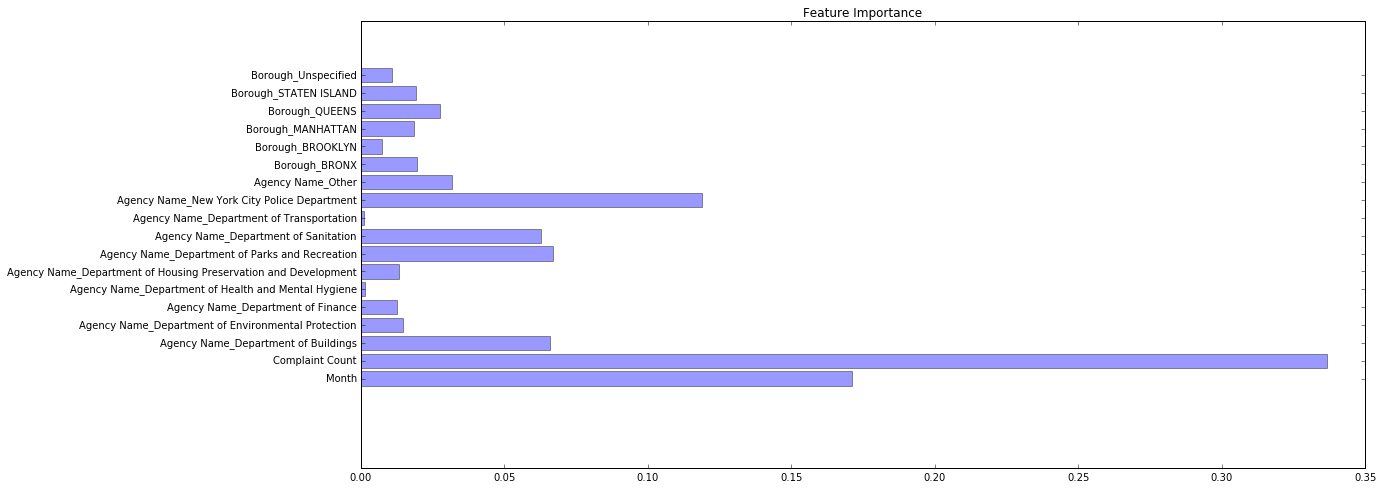

RMSE Results 17.906592859568725


In [35]:
tree_features(df3, 2017)